This is a generic script for finetuning ViLT model for VQA tasks
Simply format your data as per the requirements below and this should work.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data format
* the images (stored in a single folder)
* the questions (stored in a JSON) -- with following
* the annotations (stored in a JSON) a.k.a. the answers to the questions.

Refer to https://github.com/multimodal/multimodal/blob/master/test/data/vqa2/val/v2_OpenEnded_mscoco_val2014_questions.json for a sample of how question json file should look like.

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.4 MB/s eta 0:00:00


In [3]:
import os
home = '/content/drive/MyDrive/ReadyForFineTuning/Charts/'
imroot = home+'images'
os.chdir(home)

This piece of code converts data in VLQAv1 into desired format. If multiple images are there, it automatically merges them into one.

In [4]:
prefix = 'charts'

In [45]:
#!rm /content/blocksworld_truncated_viltft.jsonl

import json
import ast

dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "clevrhyp", "license": {}, "data_subtype": prefix,
    "questions": [] }

with open(home+prefix+'.jsonl') as f:
  data = f.readlines()
  print(len(data))
  for i in data:
    ijson = json.loads(i)
    imlist = ast.literal_eval(ijson['images'])
    anslist = [str(i) for i in ast.literal_eval(ijson['answer_choices'])]
    #if len(imlist) == 2:
    #  mpath = mergeim(imlist[0], imlist[1])
    # mpath
    dumpdict['questions'].append( { "image_id": imroot+'/'+imlist[0].replace("./images/","",1), "question": ijson['question']+" "+ijson['passage'], "question_id": ijson['qid'], "answer_choices": anslist, "answer_id": int(ijson['answer']) } )

with open('/content/'+prefix+'_viltft.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

print(dumpdict)

251
{'info': {}, 'task_type': 'Open-Ended', 'data_type': 'clevrhyp', 'license': {}, 'data_subtype': 'charts', 'questions': [{'image_id': '/content/drive/MyDrive/ReadyForFineTuning/Charts/images/21.png', 'question': 'From the above graph infer comparatively which country is most likely to have highest per capita income? The above visualization shows health care expenditure across countries. There is a strong correlation between health care expenditure and national income. The countries which spend more on health care are more likely to have highest per capita income.', 'question_id': 2218, 'answer_choices': ['United States', 'United Kingdom', 'India', 'Iraq'], 'answer_id': 0}, {'image_id': '/content/drive/MyDrive/ReadyForFineTuning/Charts/images/21.png', 'question': 'How many countries are most likely to have better per capita income level than Iraq? The above visualization shows health care expenditure across countries. There is a strong correlation between health care expenditure and 

### Read questions

First, we read the questions.

In [46]:
import json
f = open('/content/'+prefix+'_viltft.jsonl','r')
data_questions = json.load(f)
questions = data_questions['questions']

print(data_questions.keys())
print("Number of questions:", len(questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 251


That's quite a lot! Let's take a look at the first one:

In [47]:
questions[0]

{'image_id': '/content/drive/MyDrive/ReadyForFineTuning/Charts/images/21.png',
 'question': 'From the above graph infer comparatively which country is most likely to have highest per capita income? The above visualization shows health care expenditure across countries. There is a strong correlation between health care expenditure and national income. The countries which spend more on health care are more likely to have highest per capita income.',
 'question_id': 2218,
 'answer_choices': ['United States', 'United Kingdom', 'India', 'Iraq'],
 'answer_id': 0}

In [48]:
from os import listdir
from os.path import isfile, join

# -- CHANGE THIS BASED ON WHERE IMAGES ARE STORED --
#root = home+'images'

file_names = [f for f in listdir(imroot) if isfile(join(imroot, f))]
print(file_names)
print(len(file_names))

['central-bank-discount-rate_Mexico.png', 'stock-of-broad-money_United_States.png', 'gdp-real-growth-rate_Puerto_Rico.png', 'gross-national-saving_United_States.png', 'exports_United_Kingdom.png', 'distribution-of-family-income-gini-index_India.png', 'distribution-of-family-income-gini-index_United_States.png', 'stock-of-direct-foreign-investment-abroad_United_States.png', 'gross-national-saving_South_Africa.png', 'gdp-real-growth-rate_Saudi_Arabia_Qatar.png', 'current-account-balance_India_European_Union.png', 'military-expenditures_United_States.png', 'commercial-bank-prime-lending-rate_Argentina.png', 'commercial-bank-prime-lending-rate_Argentina_Brazil.png', 'central-bank-discount-rate_France.png', 'gdp-real-growth-rate_Brazil.png', 'gdp-real-growth-rate_Venezuela.png', 'central-bank-discount-rate_Germany_France.png', 'reserves-of-foreign-exchange-and-gold_India.png', 'distribution-of-family-income-gini-index_United_States_Canada_Mexico.png', 'inflation-rate-consumer-prices_United_

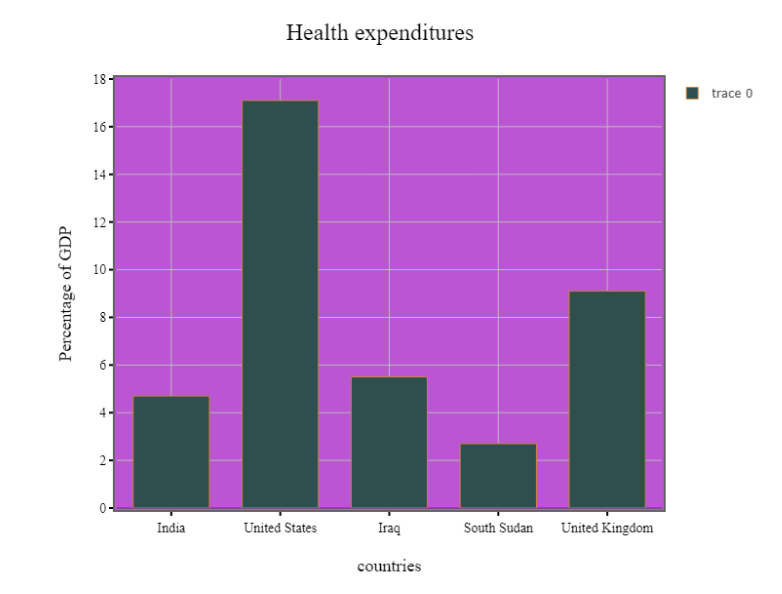

In [49]:
from PIL import Image

path = questions[0]['image_id']
image = Image.open(path)
image

In [50]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

## Create PyTorch dataset

Next, we create a regular [PyTorch dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). We leverage `ViltProcessor` to prepare each image + text pair for the model, which will automatically:
* leverage `BertTokenizerFast` to tokenize the text and create `input_ids`, `attention_mask` and `token_type_ids`
* leverage `ViltFeatureExtractor` to resize + normalize the image and create `pixel_values` and `pixel_mask`.

Note that the docs of `ViltProcessor` can be found [here](https://huggingface.co/docs/transformers/master/en/model_doc/vilt#transformers.ViltProcessor).

We also add the labels. This is a PyTorch tensor of shape `(num_labels,)` that contains the soft encoded vector.

In [61]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):

    def __init__(self, questions, processor): #annotations
        self.questions = questions
        #self.annotations = annotations
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        # get image + text
        #annotation = self.annotations[idx]
        questions = self.questions[idx]
        #image = Image.open(id_to_filename[annotation['image_id']])
        image = Image.open(questions['image_id']).convert("RGB")
        text = questions['question']
        #print(image)
        #print(text)
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        # add labels
        #labels = questions['answer_choices'][questions['answer_id']] #annotation['labels']
        #scores = [1.0] #annotation['scores']
        # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        #print(len(questions['answer_choices']))
        targets = torch.zeros(4) #len(questions['answer_choices'])
        targets[questions['answer_id']] = 1.0
        #print(targets)
        #for label, score in zip(labels, scores):
        #      targets[label] = score
        encoding["labels"] = targets
        #print(encoding)
        #print(labels)
        #print(scores)

        return encoding

In [18]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

In [62]:
dataset = VQADataset(questions=questions,processor=processor) ##annotations=annotations[:10],

In [63]:
dataset[1].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [64]:
processor.decode(dataset[0]['input_ids'])

'[CLS] from the above graph infer comparatively which country is most likely to have highest per capita income? the above visualization shows health care expenditure across countries. there is a strong correlation between health care [SEP]'

In [65]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()

## Define model

Here we define a `ViltForQuestionAnswering` model, with the weights of the body initialized from dandelin/vilt-b32-mlm, and a randomly initialized classification head. We also move it to the GPU, if it's available.

In [66]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm", num_labels=4)

model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.3.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [67]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  #print(pixel_values)
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  # create padded pixel values and corresponding pixel mask
  #encoding = processor.feature_extractor.pad_and_create_pixel_mask(pixel_values, return_tensors="pt")

  # create new batch
  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = torch.stack(pixel_values) #encoding['pixel_values']
  #batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)

Let's verify a batch:

In [68]:
batch = next(iter(train_dataloader))

In [69]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([1, 40])
attention_mask torch.Size([1, 40])
token_type_ids torch.Size([1, 40])
pixel_values torch.Size([1, 3, 384, 512])
labels torch.Size([1, 4])


## Train a model

Finally, let's train a model!

In [70]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# -- CHANGE BASED ON HOW MANY EPOCHS YOU WANT TO RUN FOR
e = 5

model.train()
for epoch in range(e):  # loop over the dataset multiple times
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/251 [00:00<?, ?it/s]

Loss: 3.6594316959381104
Loss: 2.4833791255950928
Loss: 1.9882683753967285
Loss: 3.2722134590148926
Loss: 3.485729455947876
Loss: 2.710413694381714
Loss: 3.5079550743103027
Loss: 2.716737747192383
Loss: 2.7838687896728516
Loss: 2.4034531116485596
Loss: 2.1394968032836914
Loss: 2.166621685028076
Loss: 1.8225464820861816
Loss: 2.604024887084961
Loss: 1.481251835823059
Loss: 1.353212594985962
Loss: 4.11020565032959
Loss: 1.0707190036773682
Loss: 0.9341171979904175
Loss: 2.9065282344818115
Loss: 2.9058635234832764
Loss: 0.8188656568527222
Loss: 2.7414913177490234
Loss: 0.8364032506942749
Loss: 4.113491058349609
Loss: 2.346541166305542
Loss: 4.788138389587402
Loss: 1.9441639184951782
Loss: 4.240093231201172
Loss: 4.494708061218262
Loss: 1.6568524837493896
Loss: 1.4125256538391113
Loss: 3.939682722091675
Loss: 3.711503744125366
Loss: 2.1590893268585205
Loss: 2.3500125408172607
Loss: 3.363776683807373
Loss: 1.5041890144348145
Loss: 2.990410327911377
Loss: 2.1323020458221436
Loss: 2.5221142768

  0%|          | 0/251 [00:00<?, ?it/s]

Loss: 1.8853650093078613
Loss: 3.0475523471832275
Loss: 1.4193339347839355
Loss: 3.7753891944885254
Loss: 1.9229621887207031
Loss: 3.7588350772857666
Loss: 1.9621084928512573
Loss: 1.3595246076583862
Loss: 1.368869662284851
Loss: 3.5866260528564453
Loss: 3.4651103019714355
Loss: 1.360581874847412
Loss: 3.110247850418091
Loss: 2.0549211502075195
Loss: 4.141388893127441
Loss: 2.6167759895324707
Loss: 3.450208902359009
Loss: 2.365684747695923
Loss: 3.328296661376953
Loss: 1.8660119771957397
Loss: 1.8777951002120972
Loss: 2.43461537361145
Loss: 2.4143407344818115
Loss: 2.4095640182495117
Loss: 2.931863784790039
Loss: 2.32374906539917
Loss: 1.849273443222046
Loss: 2.0821919441223145
Loss: 2.7955703735351562
Loss: 2.565082311630249
Loss: 2.459307909011841
Loss: 1.9841513633728027
Loss: 2.774174213409424
Loss: 2.3043291568756104
Loss: 2.106175422668457
Loss: 2.686893939971924
Loss: 1.7978541851043701
Loss: 1.842499017715454
Loss: 3.8593153953552246
Loss: 2.6246445178985596
Loss: 2.85175681114

  0%|          | 0/251 [00:00<?, ?it/s]

Loss: 1.4759650230407715
Loss: 2.5111382007598877
Loss: 3.075428009033203
Loss: 2.6407127380371094
Loss: 1.371065378189087
Loss: 2.644382953643799
Loss: 1.350247859954834
Loss: 2.5641486644744873
Loss: 2.6280698776245117
Loss: 1.3203370571136475
Loss: 1.331735372543335
Loss: 1.2917797565460205
Loss: 1.2581394910812378
Loss: 2.575622081756592
Loss: 2.5047874450683594
Loss: 2.486721992492676
Loss: 1.192440152168274
Loss: 4.363508701324463
Loss: 4.332511901855469
Loss: 2.8674564361572266
Loss: 1.7986392974853516
Loss: 1.7758090496063232
Loss: 2.7568535804748535
Loss: 1.9081833362579346
Loss: 3.593158721923828
Loss: 1.6269803047180176
Loss: 1.7380304336547852
Loss: 2.47367525100708
Loss: 1.3577792644500732
Loss: 1.2869126796722412
Loss: 1.3342090845108032
Loss: 2.682115316390991
Loss: 2.702880859375
Loss: 3.3285181522369385
Loss: 1.2995156049728394
Loss: 2.964081048965454
Loss: 1.1533092260360718
Loss: 2.9866788387298584
Loss: 1.1486947536468506
Loss: 2.841946601867676
Loss: 2.692767381668

  0%|          | 0/251 [00:00<?, ?it/s]

Loss: 1.980778455734253
Loss: 1.913435697555542
Loss: 2.1657962799072266
Loss: 2.2390482425689697
Loss: 1.8222724199295044
Loss: 2.3246006965637207
Loss: 1.8044517040252686
Loss: 2.868746757507324
Loss: 1.7618637084960938
Loss: 2.1964590549468994
Loss: 2.344449520111084
Loss: 2.3623454570770264
Loss: 1.6654253005981445
Loss: 2.9710230827331543
Loss: 2.3382387161254883
Loss: 2.2222800254821777
Loss: 1.6128895282745361
Loss: 2.299126625061035
Loss: 2.273499011993408
Loss: 2.1852869987487793
Loss: 1.6287389993667603
Loss: 2.169722080230713
Loss: 2.338824510574341
Loss: 2.3035707473754883
Loss: 2.714348554611206
Loss: 2.236121654510498
Loss: 2.004725933074951
Loss: 1.9330809116363525
Loss: 1.9646854400634766
Loss: 1.8516281843185425
Loss: 1.824845314025879
Loss: 2.6142377853393555
Loss: 2.1681487560272217
Loss: 2.467822551727295
Loss: 2.4703025817871094
Loss: 2.4755499362945557
Loss: 2.364363670349121
Loss: 2.641125202178955
Loss: 2.3413870334625244
Loss: 1.5958998203277588
Loss: 2.4827637

  0%|          | 0/251 [00:00<?, ?it/s]

Loss: 2.3421945571899414
Loss: 2.30329966545105
Loss: 1.7068793773651123
Loss: 1.7075181007385254
Loss: 2.8629941940307617
Loss: 2.1406972408294678
Loss: 1.6904078722000122
Loss: 2.078681468963623
Loss: 2.034363269805908
Loss: 2.8535513877868652
Loss: 2.7223410606384277
Loss: 1.886377215385437
Loss: 2.85819149017334
Loss: 2.752542495727539
Loss: 2.660435199737549
Loss: 1.753239393234253
Loss: 2.0488975048065186
Loss: 2.4579594135284424
Loss: 1.800438404083252
Loss: 3.08974027633667
Loss: 3.0808939933776855
Loss: 2.1715548038482666
Loss: 3.0757229328155518
Loss: 3.015496015548706
Loss: 1.862537145614624
Loss: 2.862419605255127
Loss: 1.8180910348892212
Loss: 1.8122963905334473
Loss: 1.7604777812957764
Loss: 2.099526882171631
Loss: 2.2042391300201416
Loss: 2.5260846614837646
Loss: 2.1616804599761963
Loss: 2.4572055339813232
Loss: 2.411860227584839
Loss: 3.10971999168396
Loss: 1.7694276571273804
Loss: 3.1121788024902344
Loss: 3.120965003967285
Loss: 1.827032208442688
Loss: 3.02304887771606

## Inference

Let's verify whether the model has actually learned something:

# Single Instance Inference

In [71]:
exid = 1
example = dataset[exid]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [72]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [73]:
logits = outputs.logits
predicted_class = logits.argmax(-1).item()
print("Predicted answer:", predicted_class)
print("Ground-truth answer:", dataset[exid]['labels'].argmax(-1).item())

Predicted answer: 1
Ground-truth answer: 0


# Batch Inference

In [ ]:
import csv
tasktype = "4way"
filprefix = prefix+"_"+tasktype

count = 0
st = 0
end = 251
with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  spamwriter.writerow(["qid","pred_ans","gt_ans","correctness"])
  for exid in range(st,end):
    correctness = 0
    example = dataset[exid]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    gtclass = dataset[exid]['labels'].argmax(-1).item()
    if gtclass==predicted_class:
      count+=1
      correctness = 1
    #print([exid,predicted_class, gtclass,correctness])
    spamwriter.writerow([exid,predicted_class, gtclass,correctness])